# Traffic Scaling

In [1]:
import sys
sys.path.insert(1, '../../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime, concat
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
PersistenceOptimistRegressor, PersistenceRealistRegressor, scale_all_dataframe
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

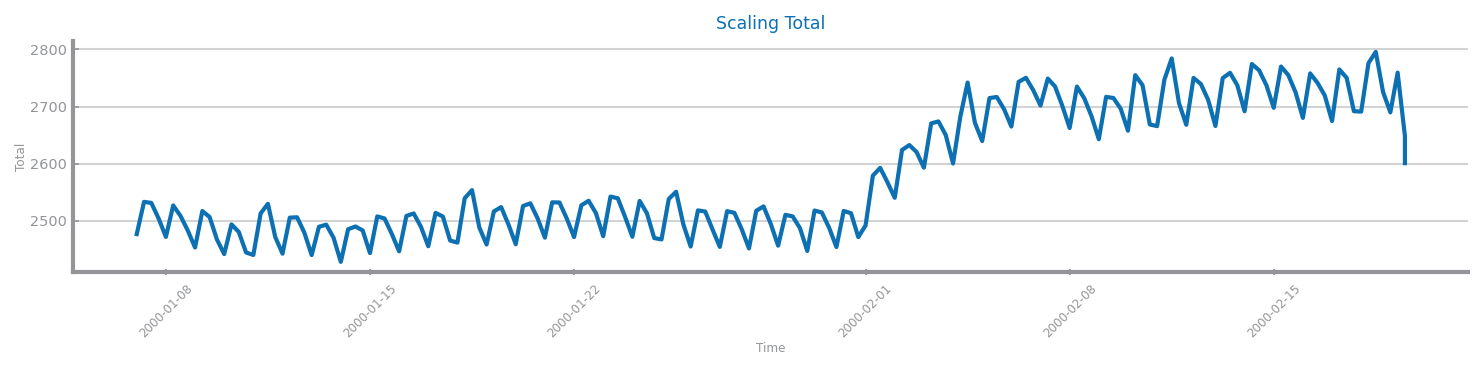

(Time
 2000-01-07 00:00:00    2476.76
 2000-01-07 06:00:00    2533.12
 2000-01-07 12:00:00    2531.36
 2000-01-07 18:00:00    2504.08
 2000-01-08 00:00:00    2471.84
 Name: Total, dtype: float64,
 Time
 2000-02-19 12:00:00    2648.44
 2000-02-19 12:00:00    2600.88
 2000-02-19 18:00:00    2599.24
 2000-02-20 00:00:00    2606.84
 2000-02-20 06:00:00    2601.40
 Name: Total, dtype: float64)

In [2]:
target = "Total"
chart_target = "Total"
file_tag = "Scaling"


train_path = "../../data/prepared/smoothing/traffic_train_smoothing.csv" 
test_path  = "../../data/prepared/smoothing/traffic_test_smoothing.csv"

train_df = read_csv(train_path, parse_dates=["Time"], index_col="Time")
train: Series = train_df[target]
train.index = to_datetime(train.index)  # ensure proper datetime index

# Load test
test_df = read_csv(test_path, parse_dates=["Time"], index_col="Time")
test: Series = test_df[target]
test.index = to_datetime(test.index)

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"{file_tag} {target}",
)
show()
train.head(), test.head()

None: train shape=(176,), test shape=(51,)
StandardScaler: train shape=(176,), test shape=(51,)
MinMaxScaler: train shape=(176,), test shape=(51,)
RobustScaler: train shape=(176,), test shape=(51,)


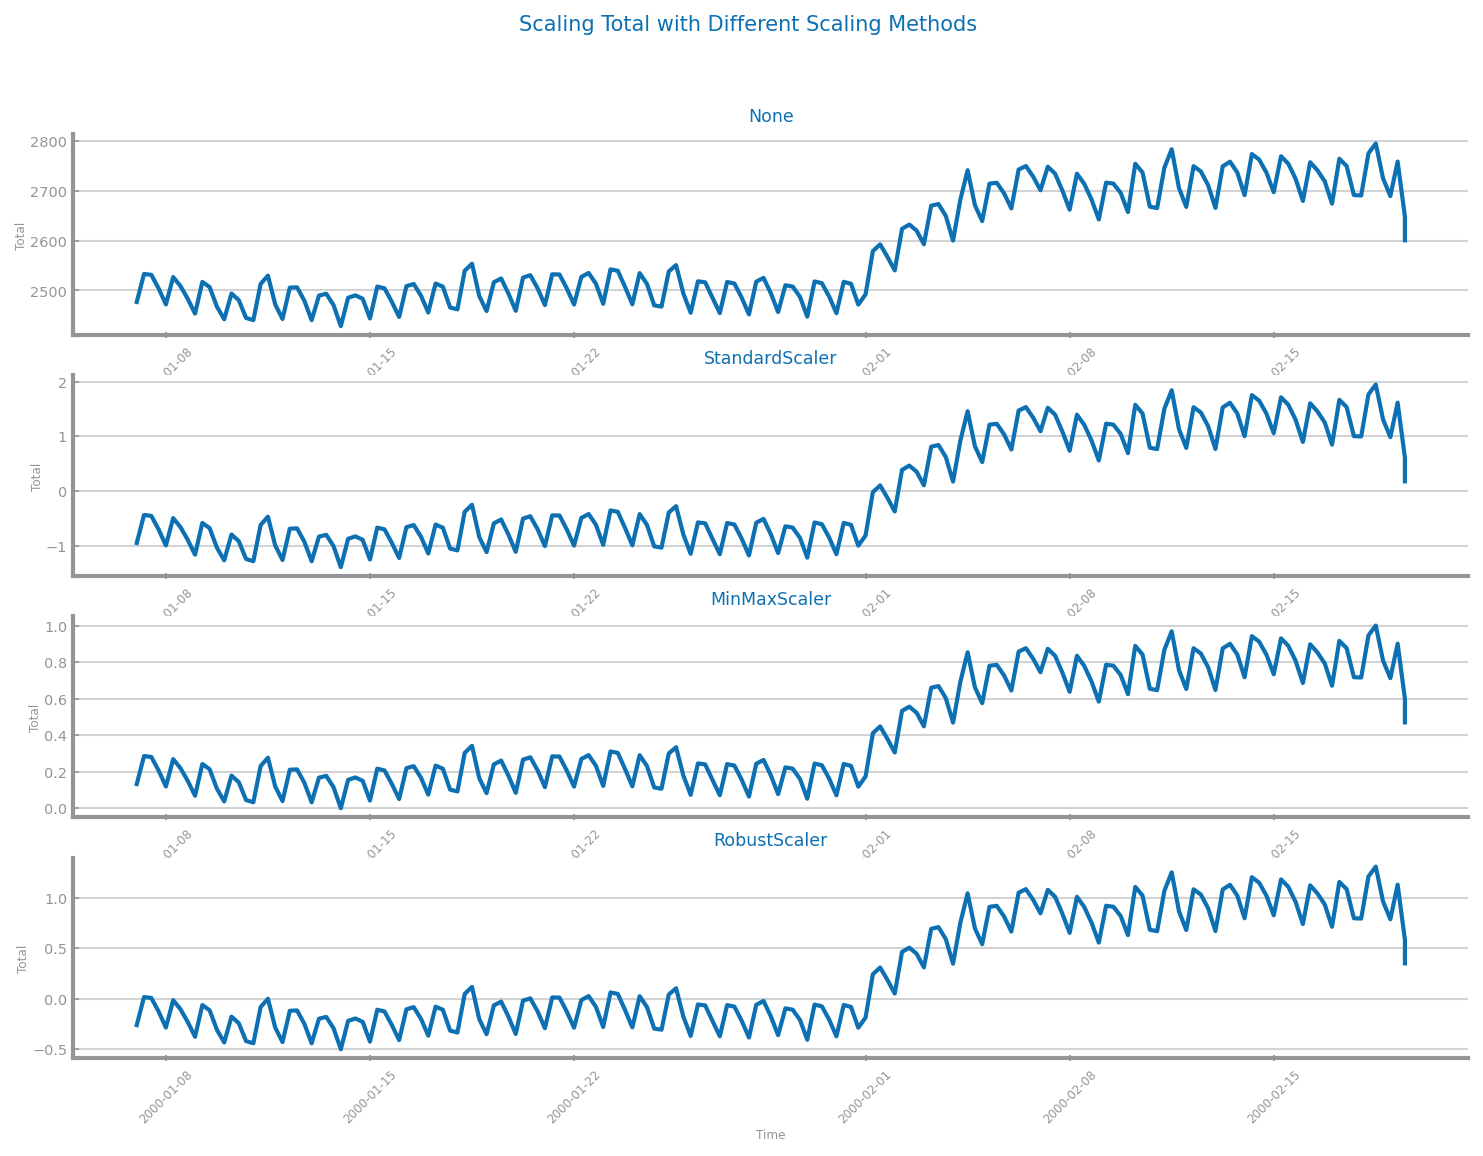

In [3]:
# Define scaling methods to evaluate
scaling_methods = {
    "None": None,  # No scaling baseline
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
}

# Apply each scaling method and store results
scaled_data = {}
fig, axs = subplots(len(scaling_methods), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(scaling_methods)))
fig.suptitle(f"{file_tag} {target} with Different Scaling Methods")

# Combine train and test for proper scaling (fit on train, transform both)
combined = concat([train, test])

for idx, (method_name, scaler) in enumerate(scaling_methods.items()):
    if method_name == "None":
        # No scaling
        scaled_train = train
        scaled_test = test
    else:
        # Fit scaler on training data only, then transform both
        scaler.fit(train.values.reshape(-1, 1))
        scaled_train_values = scaler.transform(train.values.reshape(-1, 1)).flatten()
        scaled_test_values = scaler.transform(test.values.reshape(-1, 1)).flatten()
        
        scaled_train = Series(scaled_train_values, index=train.index, name=target)
        scaled_test = Series(scaled_test_values, index=test.index, name=target)
    
    # Store scaled data
    scaled_data[f"{method_name}_train"] = scaled_train
    scaled_data[f"{method_name}_test"] = scaled_test
    
    # Plot
    ax = axs[idx] if len(scaling_methods) > 1 else axs
    plot_line_chart(
        scaled_train.index.to_list(),
        scaled_train.to_list(),
        ax=ax,
        xlabel=scaled_train.index.name,
        ylabel=target,
        title=f"{method_name}",
    )
    
    print(f"{method_name}: train shape={scaled_train.shape}, test shape={scaled_test.shape}")

show()

In [4]:
# Initialize metrics storage
metrics_results = {}

def store_metrics(model_name, scaling_method, train_series, test_series, prd_trn, prd_tst):
    """Store metrics for a given model and scaling method"""
    key = f"{model_name}_{scaling_method}"
    metrics_results[key] = {
        "model": model_name,
        "scaling_method": scaling_method,
        "train_rmse": sqrt(mean_squared_error(train_series, prd_trn)),
        "test_rmse": sqrt(mean_squared_error(test_series, prd_tst)),
        "train_mae": mean_absolute_error(train_series, prd_trn),
        "test_mae": mean_absolute_error(test_series, prd_tst),
        "train_mape": mean_absolute_percentage_error(train_series, prd_trn),
        "test_mape": mean_absolute_percentage_error(test_series, prd_tst),
        "train_r2": r2_score(train_series, prd_trn),
        "test_r2": r2_score(test_series, prd_tst),
    }
    return metrics_results[key]

PERSISTENCE REALIST EVALUATION
Completed: Persistence_Realist with None
Completed: Persistence_Realist with StandardScaler
Completed: Persistence_Realist with MinMaxScaler
Completed: Persistence_Realist with RobustScaler


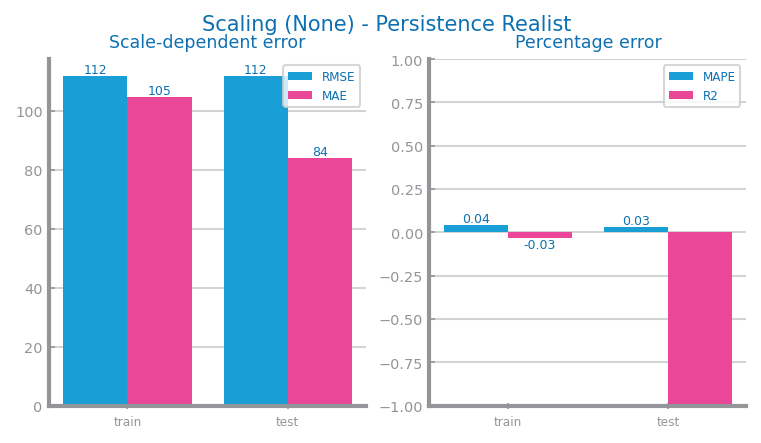

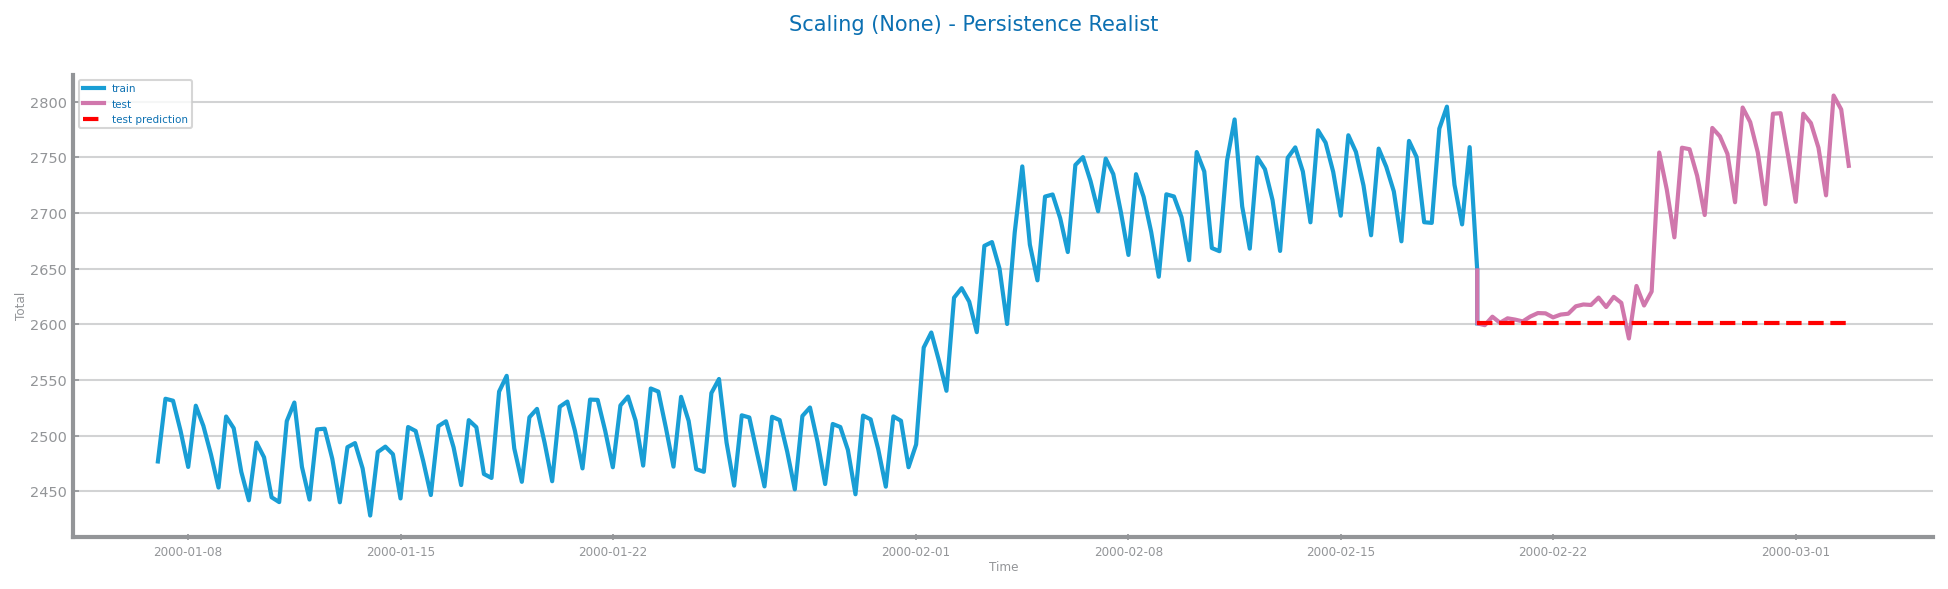

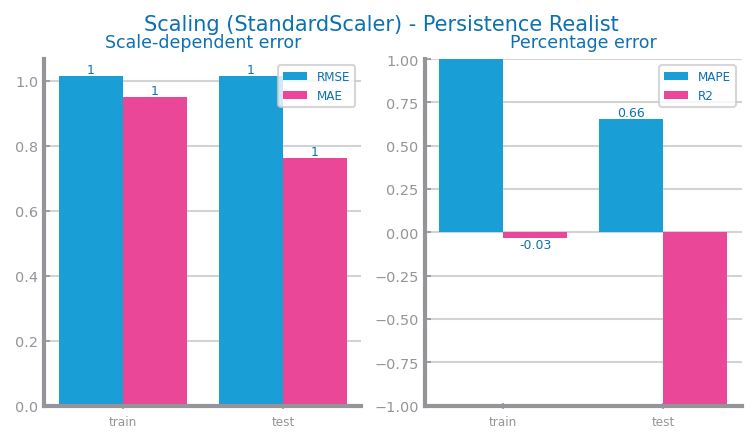

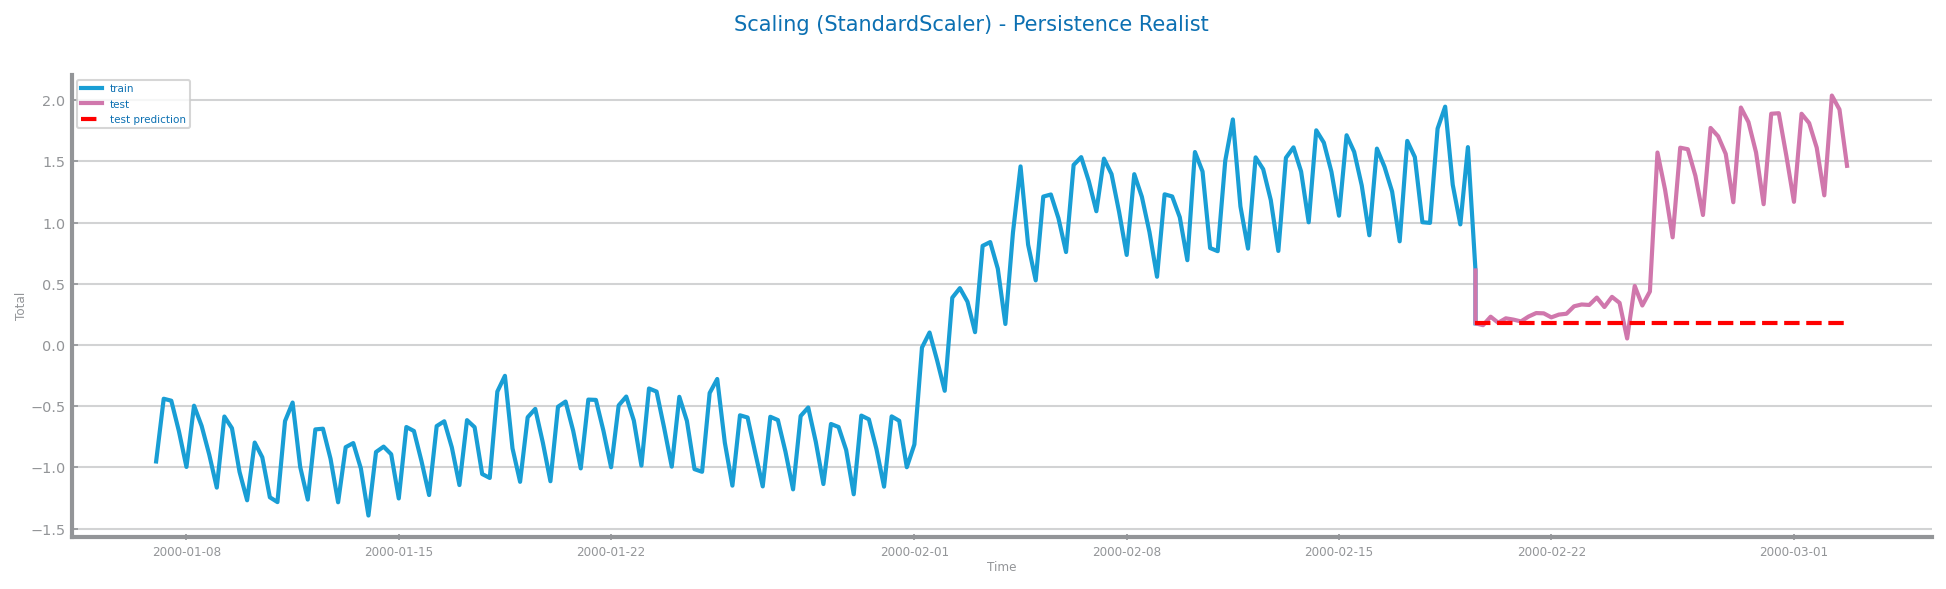

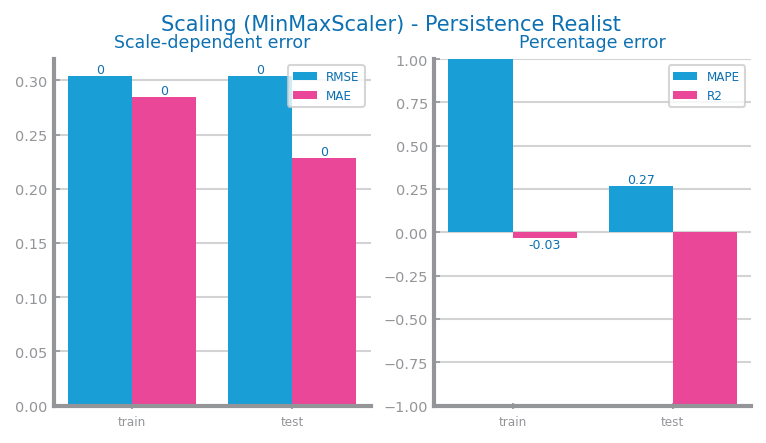

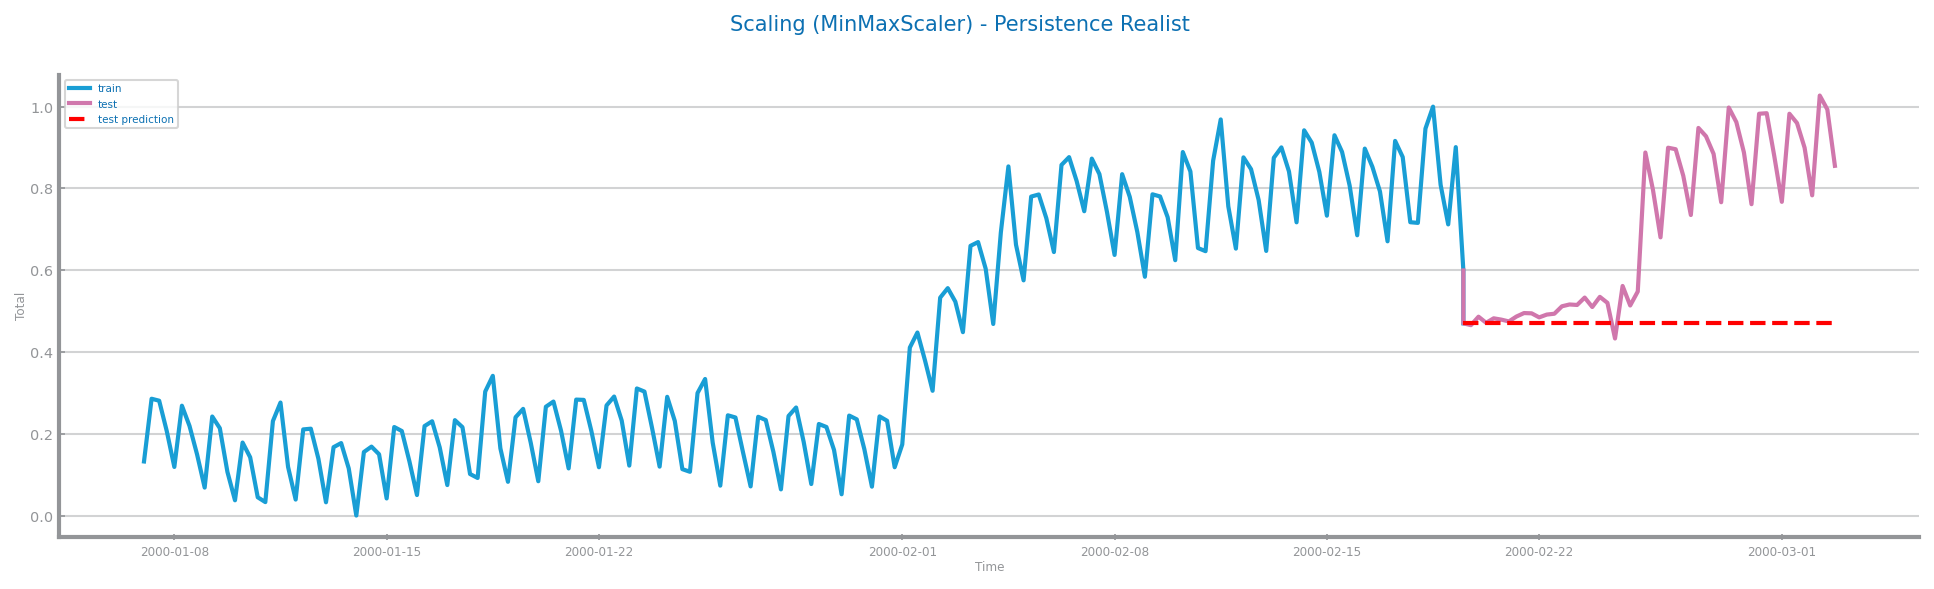

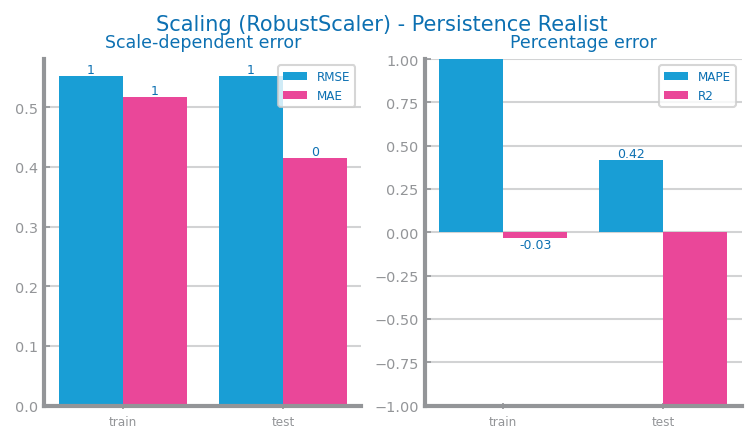

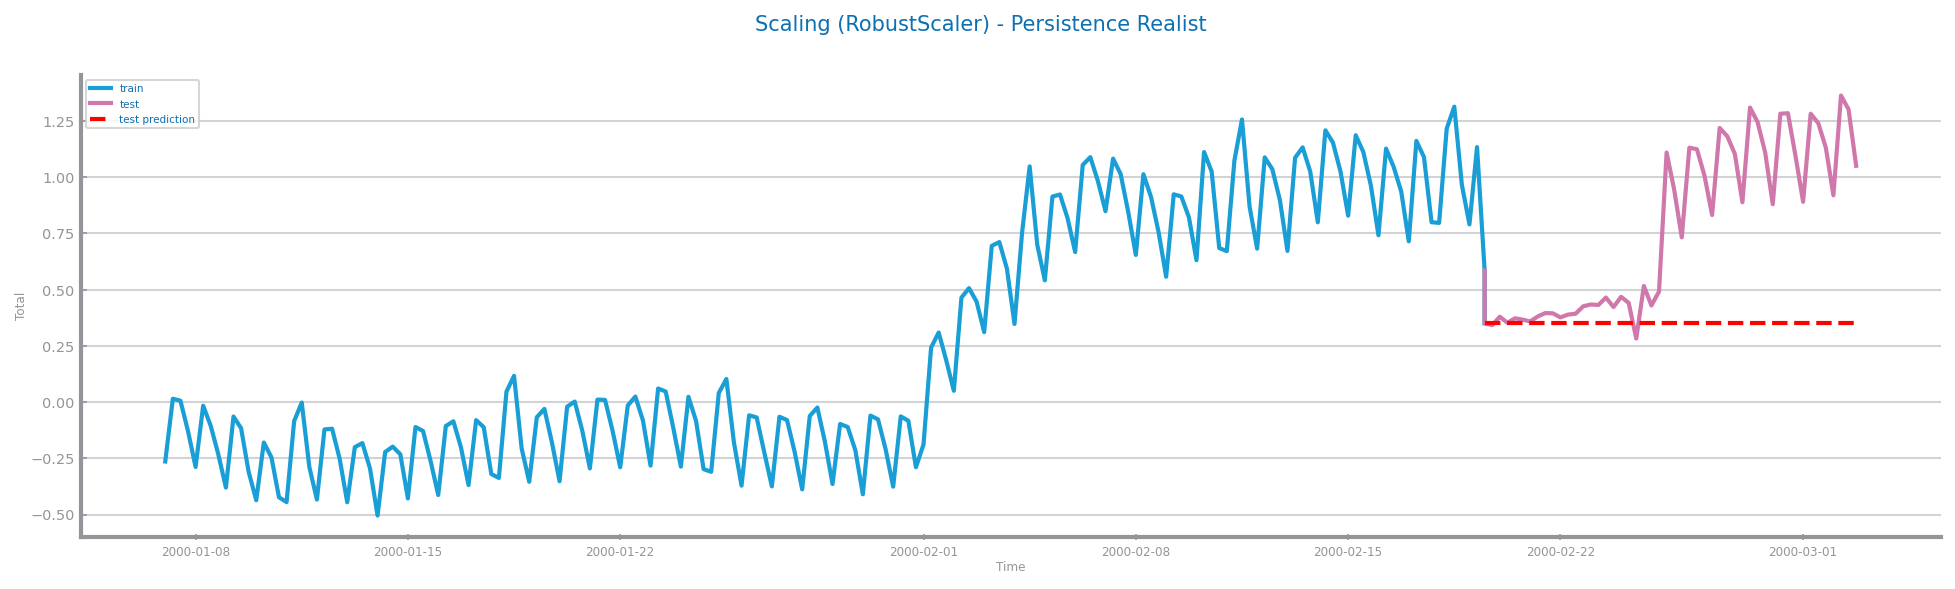

In [5]:
print("="*80)
print("PERSISTENCE REALIST EVALUATION")
print("="*80)

for method_name in scaling_methods.keys():
    scaled_train = scaled_data[f"{method_name}_train"]
    scaled_test = scaled_data[f"{method_name}_test"]
    
    # Train and predict
    fr_mod = PersistenceRealistRegressor()
    fr_mod.fit(scaled_train)
    prd_trn = fr_mod.predict(scaled_train)
    prd_tst = fr_mod.predict(scaled_test)
    
    # Store metrics
    store_metrics("Persistence_Realist", method_name, scaled_train, scaled_test, prd_trn, prd_tst)
    
    # Plot evaluation
    plot_forecasting_eval(
        scaled_train, 
        scaled_test, 
        prd_trn, 
        prd_tst, 
        title=f"{file_tag} ({method_name}) - Persistence Realist"
    )
    savefig(f"../../charts/preparation/scaling/{file_tag}_persistence_real_{method_name}_eval.png", bbox_inches='tight')
    
    # Plot forecast
    plot_forecasting_series(
        scaled_train,
        scaled_test,
        prd_tst,
        title=f"{file_tag} ({method_name}) - Persistence Realist",
        xlabel="Time",
        ylabel=target,
    )
    savefig(f"../../charts/preparation/scaling/{file_tag}_persistence_real_{method_name}_forecast.png", bbox_inches='tight')
    
    print(f"Completed: Persistence_Realist with {method_name}")

LINEAR REGRESSION EVALUATION
Completed: Linear_Regression with None
Completed: Linear_Regression with StandardScaler
Completed: Linear_Regression with MinMaxScaler
Completed: Linear_Regression with RobustScaler


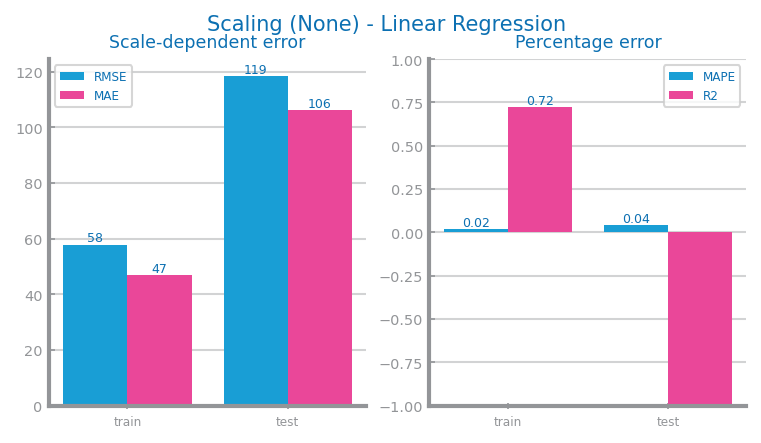

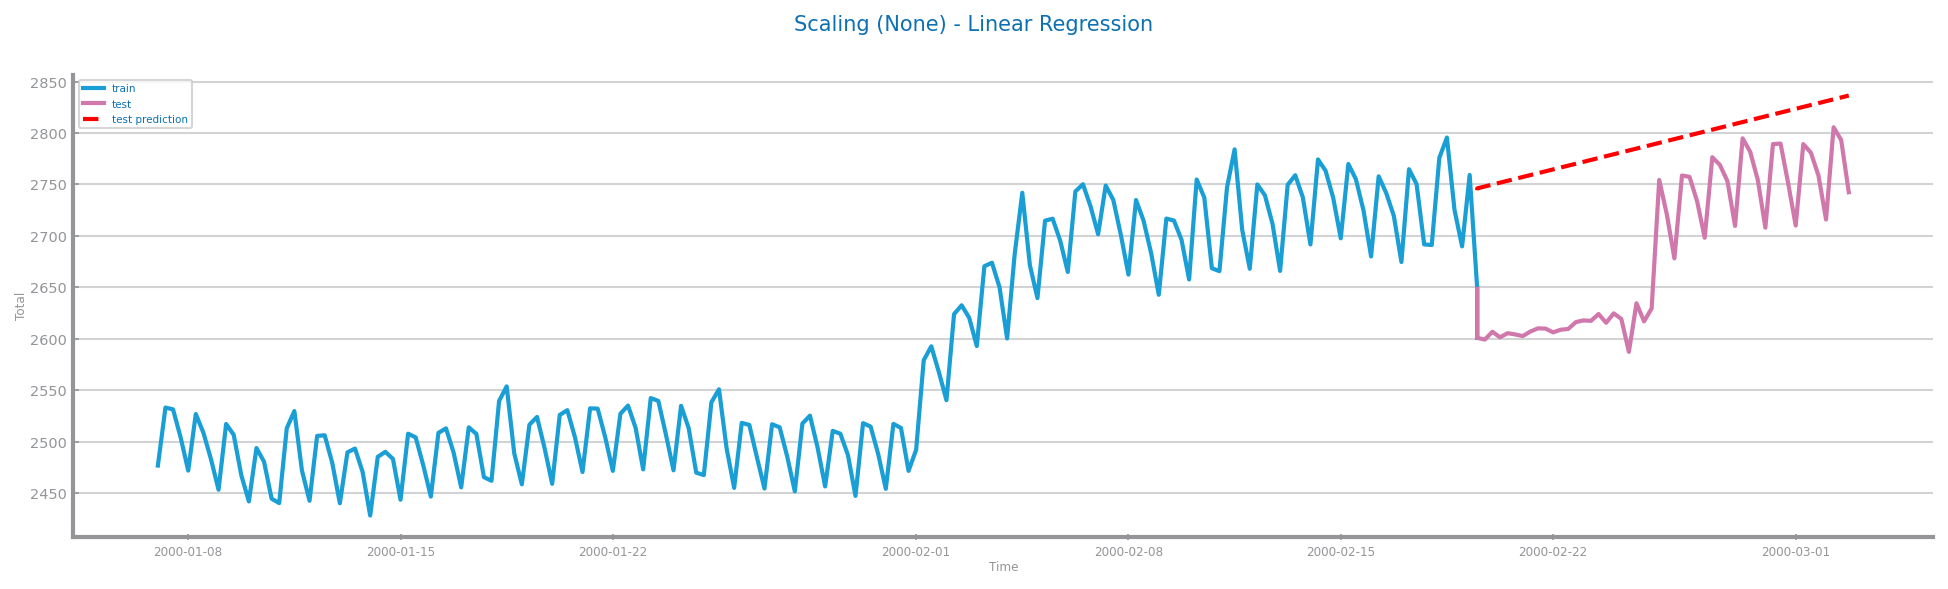

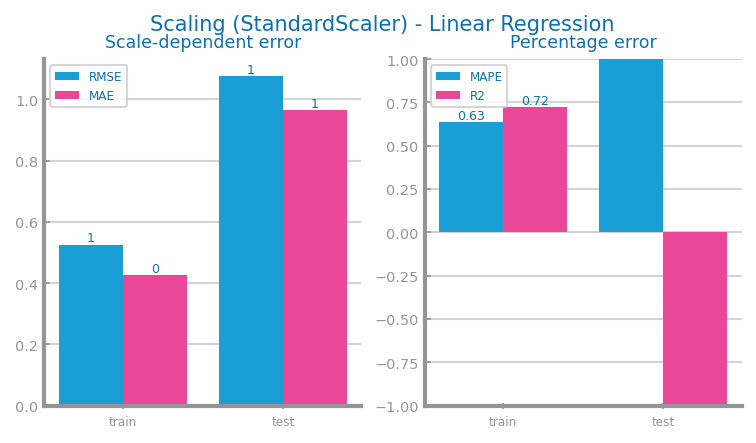

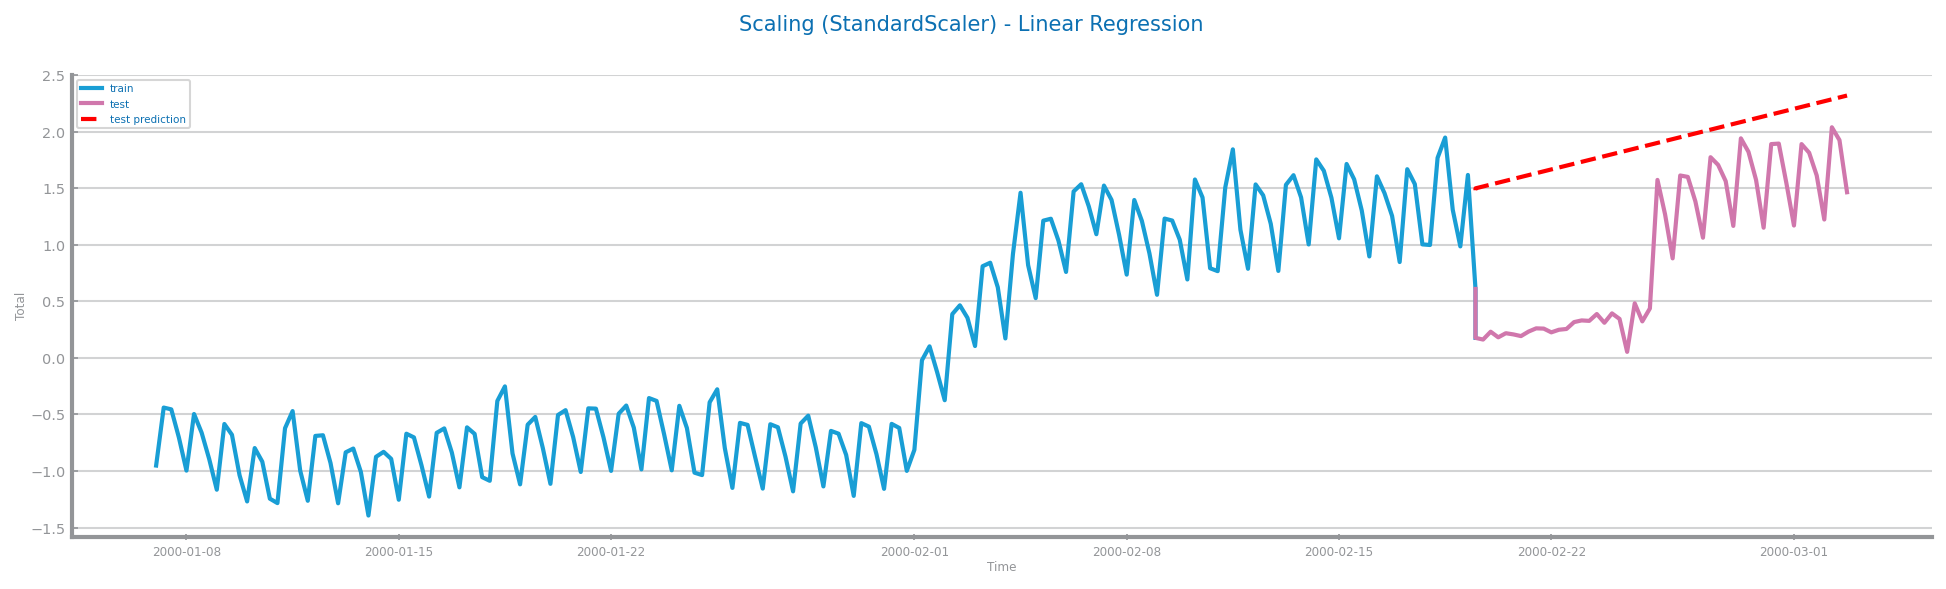

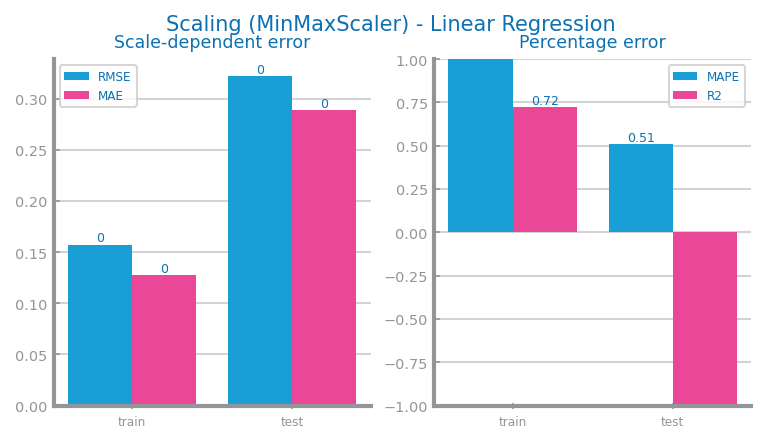

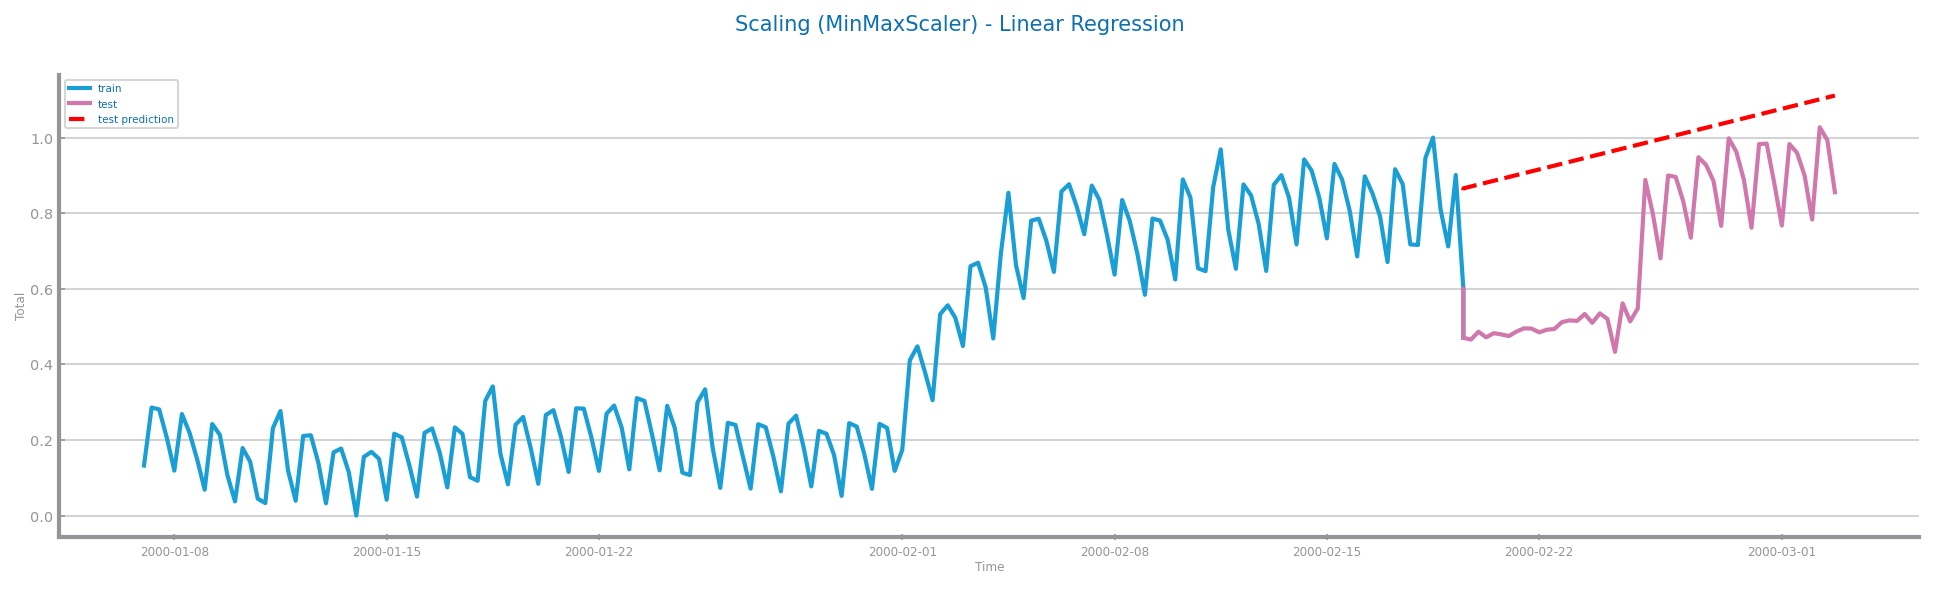

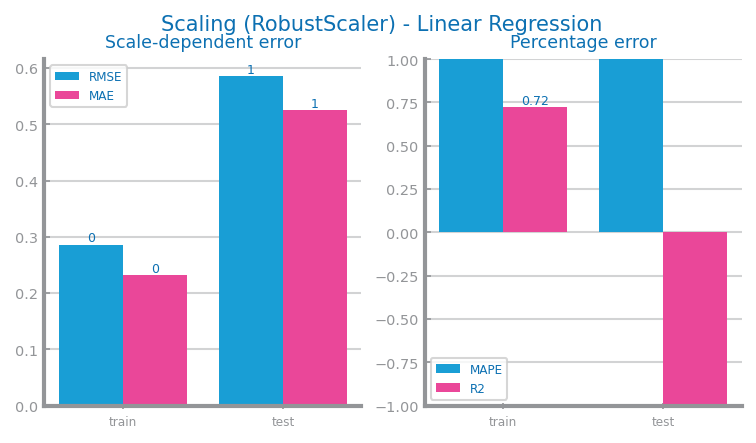

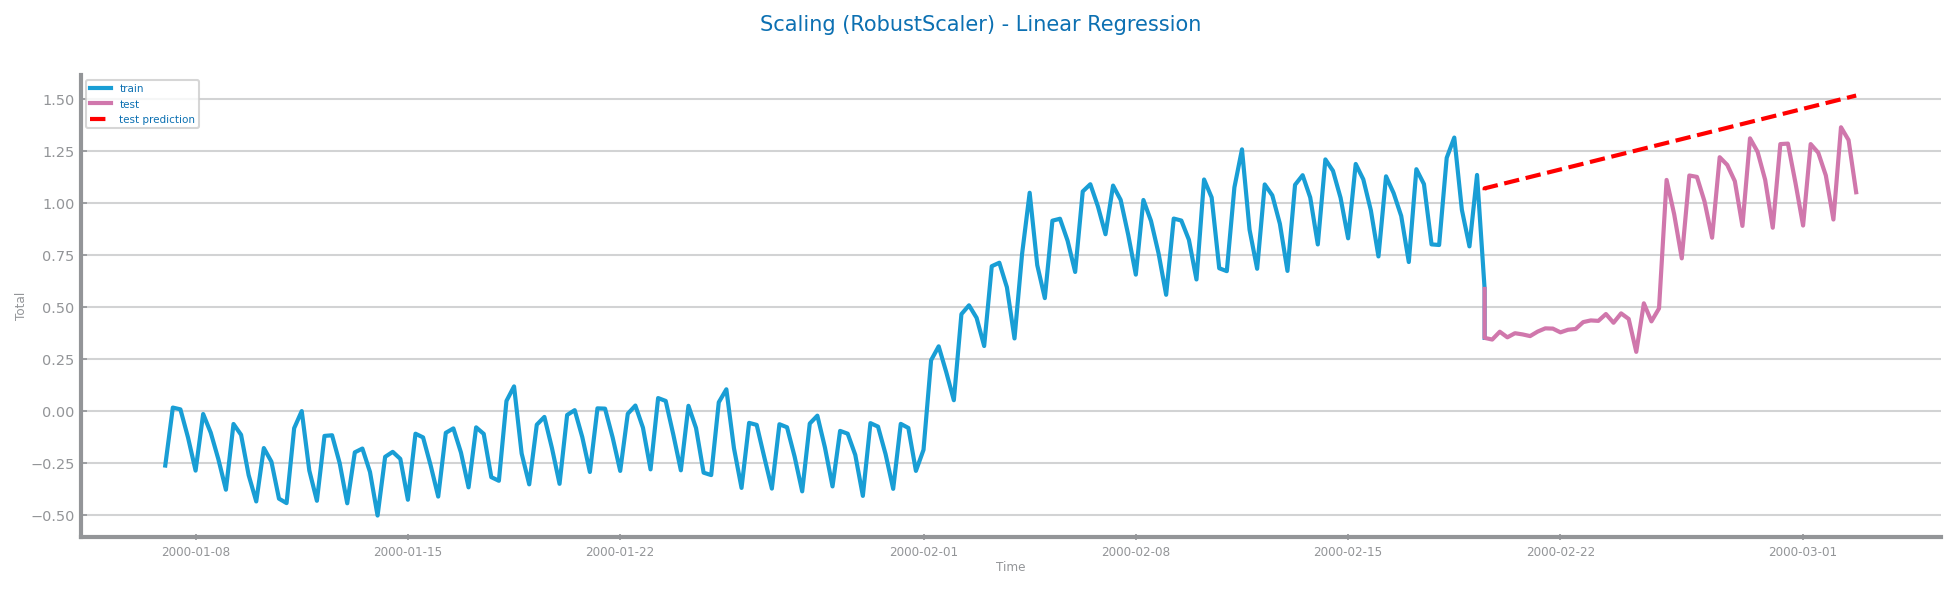

In [6]:
print("="*80)
print("LINEAR REGRESSION EVALUATION")
print("="*80)

for method_name in scaling_methods.keys():
    scaled_train = scaled_data[f"{method_name}_train"]
    scaled_test = scaled_data[f"{method_name}_test"]
    
    # Prepare data
    n_trn = len(scaled_train)
    n_tst = len(scaled_test)
    
    trnX = arange(n_trn).reshape(-1, 1)
    trnY = scaled_train.to_numpy()
    
    tstX = arange(n_trn, n_trn + n_tst).reshape(-1, 1)
    tstY = scaled_test.to_numpy()
    
    # Train model
    model = LinearRegression()
    model.fit(trnX, trnY)
    
    prd_trn = Series(model.predict(trnX), index=scaled_train.index)
    prd_tst = Series(model.predict(tstX), index=scaled_test.index)
    
    # Store metrics
    store_metrics("Linear_Regression", method_name, scaled_train, scaled_test, prd_trn, prd_tst)
    
    # Plot evaluation
    plot_forecasting_eval(
        scaled_train,
        scaled_test,
        prd_trn,
        prd_tst,
        title=f"{file_tag} ({method_name}) - Linear Regression"
    )
    savefig(f"../../charts/preparation/scaling/{file_tag}_linear_regression_{method_name}_eval.png", bbox_inches='tight')
    
    # Plot forecast
    plot_forecasting_series(
        scaled_train,
        scaled_test,
        prd_tst,
        title=f"{file_tag} ({method_name}) - Linear Regression",
        xlabel="Time",
        ylabel=target,
    )
    savefig(f"../../charts/preparation/scaling/{file_tag}_linear_regression_{method_name}_forecast.png", bbox_inches='tight')
    
    print(f"Completed: Linear_Regression with {method_name}")

In [7]:
# Convert metrics to DataFrame for easy comparison
metrics_df = DataFrame.from_dict(metrics_results, orient='index')
metrics_df = metrics_df.reset_index(drop=True)

# Display all metrics
print("="*80)
print("ALL MODEL METRICS (Test Set)")
print("="*80)
display_df = metrics_df[['model', 'scaling_method', 'test_rmse', 'test_mae', 'test_mape', 'test_r2']].copy()
display_df = display_df.sort_values(['model', 'scaling_method'])
print(display_df.to_string(index=False))
print()

# Find best models by different criteria
print("="*80)
print("BEST MODELS BY CRITERIA (Test Set)")
print("="*80)

# Best by RMSE (penalizes large errors more than MAE)
# RMSE is preferred when large errors are particularly undesirable and should be penalized more heavily
# It's in the same units as the target variable, making it interpretable
best_rmse = metrics_df.loc[metrics_df['test_rmse'].idxmin()]
print(f"Best RMSE: {best_rmse['model']} ({best_rmse['scaling_method']}) = {best_rmse['test_rmse']:.2f}")

# Best by MAPE (scale-independent, good for comparing across scaling methods)
best_mape = metrics_df.loc[metrics_df['test_mape'].idxmin()]
print(f"Best MAPE: {best_mape['model']} ({best_mape['scaling_method']}) = {best_mape['test_mape']:.4f}")

# Best by R2 (scale-independent)
best_r2 = metrics_df.loc[metrics_df['test_r2'].idxmax()]
print(f"Best R²: {best_r2['model']} ({best_r2['scaling_method']}) = {best_r2['test_r2']:.4f}")

# Best by MAE for each scaling method
print(f"\nBest MAE by Scaling Method:")
for method_name in scaling_methods.keys():
    method_df = metrics_df[metrics_df['scaling_method'] == method_name]
    best_mae_method = method_df.loc[method_df['test_mae'].idxmin()]
    print(f"  {method_name}: {best_mae_method['model']} = {best_mae_method['test_mae']:.2f}")

print()
print("="*80)
print("RECOMMENDATION (Based on RMSE)")
print("="*80)
print("Selection Criterion: RMSE (Root Mean Squared Error)")
print("Rationale: RMSE penalizes large prediction errors more heavily than MAE,")
print("           making it ideal when large deviations are particularly costly.")
print("           It's also in the same units as our target variable (traffic count).")
print("="*80)
print(f"Overall Best Model: {best_rmse['model']} with {best_rmse['scaling_method']} scaling")
print(f"  - Test RMSE: {best_rmse['test_rmse']:.2f}")
print(f"  - Test MAE: {best_rmse['test_mae']:.2f}")
print(f"  - Test MAPE: {best_rmse['test_mape']:.4f}")
print(f"  - Test R²: {best_rmse['test_r2']:.4f}")

# Store best model info for later use
best_model_name = best_rmse['model']
best_scaling_method = best_rmse['scaling_method']

ALL MODEL METRICS (Test Set)
              model scaling_method  test_rmse   test_mae  test_mape   test_r2
  Linear_Regression   MinMaxScaler   0.322608   0.288791   0.511743 -1.529388
  Linear_Regression           None 118.539231 106.113228   0.040087 -1.529388
  Linear_Regression   RobustScaler   0.586363   0.524897   1.089821 -1.529388
  Linear_Regression StandardScaler   1.077585   0.964626   3.310595 -1.529388
Persistence_Realist   MinMaxScaler   0.304428   0.228628   0.269201 -1.252337
Persistence_Realist           None 111.859044  84.007059   0.030560 -1.252337
Persistence_Realist   RobustScaler   0.553319   0.415547   0.416229 -1.252337
Persistence_Realist StandardScaler   1.016858   0.763669   0.655703 -1.252337

BEST MODELS BY CRITERIA (Test Set)
Best RMSE: Persistence_Realist (MinMaxScaler) = 0.30
Best MAPE: Persistence_Realist (None) = 0.0306
Best R²: Persistence_Realist (None) = -1.2523

Best MAE by Scaling Method:
  None: Persistence_Realist = 84.01
  StandardScaler: Pers

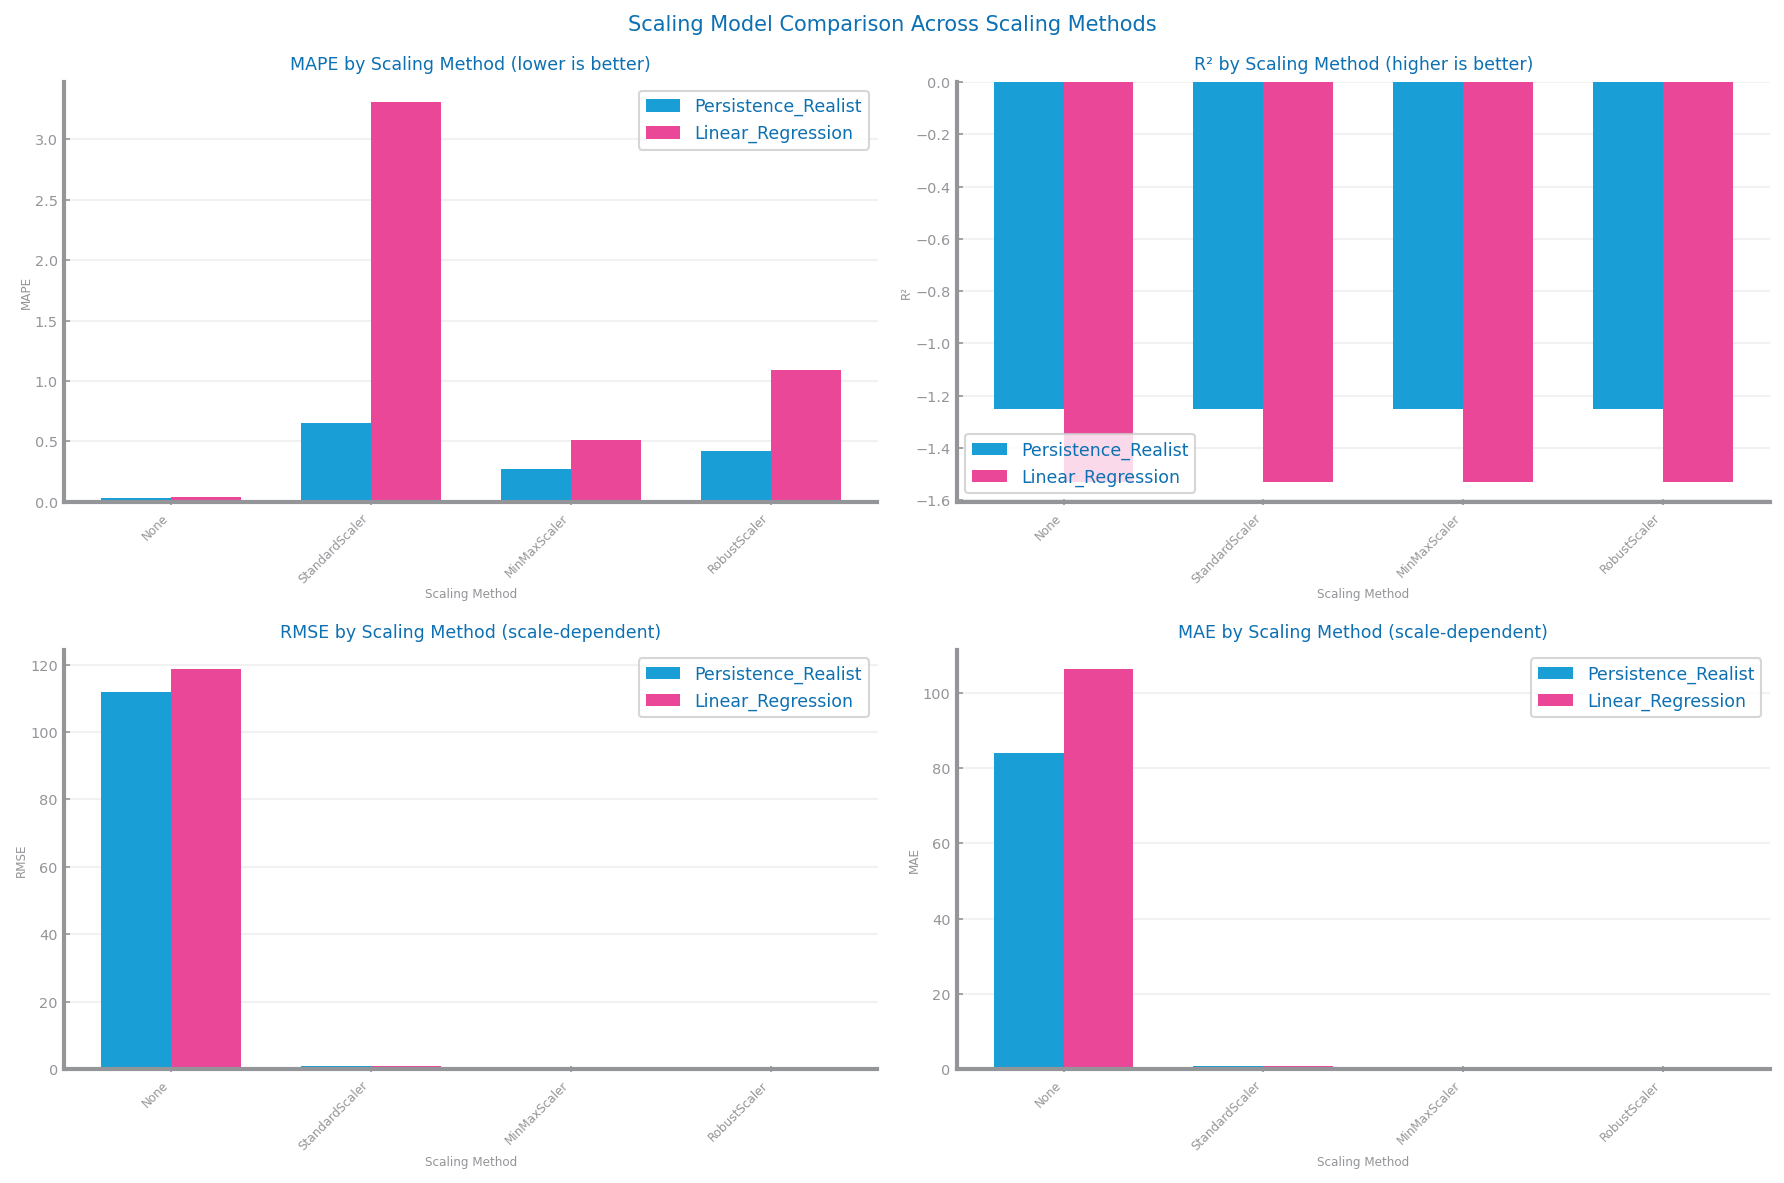

In [8]:
# Visualize model comparison
fig, axs = subplots(2, 2, figsize=(3 * HEIGHT, 2 * HEIGHT))
fig.suptitle(f"{file_tag} Model Comparison Across Scaling Methods")

# Prepare data for plotting
models = metrics_df['model'].unique()
scaling_method_names = list(scaling_methods.keys())

# Plot 1: MAPE comparison (lower is better)
x_pos = arange(len(scaling_method_names))
width = 0.35
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df['model'] == model].sort_values('scaling_method', 
                                                                       key=lambda x: x.map({m: idx for idx, m in enumerate(scaling_method_names)}))
    axs[0, 0].bar(x_pos + i*width, model_data['test_mape'], width, label=model)
axs[0, 0].set_title('MAPE by Scaling Method (lower is better)')
axs[0, 0].set_xlabel('Scaling Method')
axs[0, 0].set_ylabel('MAPE')
axs[0, 0].set_xticks(x_pos + width / 2)
axs[0, 0].set_xticklabels(scaling_method_names, rotation=45, ha='right')
axs[0, 0].legend(fontsize='small')
axs[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: R² comparison (higher is better)
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df['model'] == model].sort_values('scaling_method', 
                                                                       key=lambda x: x.map({m: idx for idx, m in enumerate(scaling_method_names)}))
    axs[0, 1].bar(x_pos + i*width, model_data['test_r2'], width, label=model)
axs[0, 1].set_title('R² by Scaling Method (higher is better)')
axs[0, 1].set_xlabel('Scaling Method')
axs[0, 1].set_ylabel('R²')
axs[0, 1].set_xticks(x_pos + width / 2)
axs[0, 1].set_xticklabels(scaling_method_names, rotation=45, ha='right')
axs[0, 1].legend(fontsize='small')
axs[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: RMSE comparison
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df['model'] == model].sort_values('scaling_method', 
                                                                       key=lambda x: x.map({m: idx for idx, m in enumerate(scaling_method_names)}))
    axs[1, 0].bar(x_pos + i*width, model_data['test_rmse'], width, label=model)
axs[1, 0].set_title('RMSE by Scaling Method (scale-dependent)')
axs[1, 0].set_xlabel('Scaling Method')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].set_xticks(x_pos + width / 2)
axs[1, 0].set_xticklabels(scaling_method_names, rotation=45, ha='right')
axs[1, 0].legend(fontsize='small')
axs[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: MAE comparison
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df['model'] == model].sort_values('scaling_method', 
                                                                       key=lambda x: x.map({m: idx for idx, m in enumerate(scaling_method_names)}))
    axs[1, 1].bar(x_pos + i*width, model_data['test_mae'], width, label=model)
axs[1, 1].set_title('MAE by Scaling Method (scale-dependent)')
axs[1, 1].set_xlabel('Scaling Method')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].set_xticks(x_pos + width / 2)
axs[1, 1].set_xticklabels(scaling_method_names, rotation=45, ha='right')
axs[1, 1].legend(fontsize='small')
axs[1, 1].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
savefig(f"../../charts/preparation/scaling/{file_tag}_model_comparison.png", bbox_inches='tight')
show()

In [9]:
output_train_path = "../../data/prepared/scaling/traffic_train_scaling.csv"
output_test_path  = "../../data/prepared/scaling/traffic_test_scaling.csv"

# Select the best scaled series based on MAPE
best_scaled_train = scaled_data[f"{best_scaling_method}_train"]
best_scaled_test = scaled_data[f"{best_scaling_method}_test"]

# Ensure they are DataFrames so the index is preserved cleanly
best_scaled_train.to_frame(name="Total").to_csv(output_train_path)
best_scaled_test.to_frame(name="Total").to_csv(output_test_path)

print(f"Saved {best_scaling_method} scaled train/test sets (best model: {best_model_name}).")
print(f"Train shape: {best_scaled_train.shape}")
print(f"Test shape: {best_scaled_test.shape}")

Saved MinMaxScaler scaled train/test sets (best model: Persistence_Realist).
Train shape: (176,)
Test shape: (51,)


# Best Model Comparison

In [10]:
# Save metrics to CSV for reference
metrics_output_path = "../../data/prepared/scaling/traffic_scaling_metrics.csv"
metrics_df.to_csv(metrics_output_path, index=False)
print(f"Saved metrics to {metrics_output_path}")

# Display summary
metrics_df

Saved metrics to ../../data/prepared/scaling/traffic_scaling_metrics.csv


,model,scaling_method,train_rmse,test_rmse,train_mae,test_mae,train_mape,test_mape,train_r2,test_r2
0,Persistence_Realist,None,111.715752,111.859044,104.647955,84.007059,4.057885e-02,0.030560,-0.031353,-1.252337
1,Persistence_Realist,StandardScaler,1.015556,1.016858,0.951306,0.763669,1.124044e+00,0.655703,-0.031353,-1.252337
2,Persistence_Realist,MinMaxScaler,0.304038,0.304428,0.284803,0.228628,1.202827e+13,0.269201,-0.031353,-1.252337
3,Persistence_Realist,RobustScaler,0.552611,0.553319,0.517649,0.415547,5.310731e+00,0.416229,-0.031353,-1.252337
4,Linear_Regression,None,57.865682,118.539231,46.841821,106.113228,1.818575e-02,0.040087,0.723293,-1.529388
5,Linear_Regression,StandardScaler,0.526030,1.077585,0.425817,0.964626,6.348945e-01,3.310595,0.723293,-1.529388
6,Linear_Regression,MinMaxScaler,0.157483,0.322608,0.127482,0.288791,3.041691e+12,0.511743,0.723293,-1.529388
7,Linear_Regression,RobustScaler,0.286237,0.586363,0.231707,0.524897,3.131515e+00,1.089821,0.723293,-1.529388
